<a href="https://colab.research.google.com/github/Cutie-tee/Roboreviews_project/blob/main/Clustering_with_zero_classifcation_topic_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset consists of 3 files: 1429_1.csv
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv
Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv




In [ ]:
combined_data['reviews.username'] = combined_data['reviews.username'].fillna("Anonymous")
combined_data['name'] = combined_data['name'].fillna("Unknown")

combined_data['reviews.doRecommend'] = combined_data['reviews.doRecommend'].map({'Yes': True, 'No': False})

assert combined_data['reviews.rating'].between(1, 5).all()

combined_data.to_csv('final_preprocessed_reviews.csv', index=False)
print("Final preprocessed dataset saved.")



Final preprocessed dataset saved.


**Sentinent analysis  with RoBerta-base**

**Clustering based on emrging trends to ascertain partner growth opportuntities** . Lifestyle Enhancers:

Products designed to improve daily routines or convenience.
Includes items like Nespresso pods, smart assistants, pet carriers, and other gadgets that simplify life.
Creative and Productivity Tools:

Products for work, study, or creative activities.
Includes laptops, tablets, keyboards, laptop stands, webcams, and styluses.
Health and Wellness:

Devices that focus on personal health, fitness, or beauty.
Includes fitness trackers, electric massagers, hairdryers, and grooming devices.
Entertainment and Immersion:

Products that provide entertainment or enhanced experiences.
Includes gaming consoles, headphones, speakers, VR headsets, and streaming devices.
Power and Connectivity Solutions:

Products that enable devices to stay powered or connected.
Includes chargers, batteries, power banks, docking stations, and USB hubs.
Eco-Friendly and Sustainable Solutions:

Products marketed as sustainable or environmentally friendly.

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# Import necessary libraries
from transformers import pipeline
import pandas as pd
import torch
from datasets import Dataset
from tqdm.notebook import tqdm

# Check GPU availability
print("Checking if we have a GPU...")
if torch.cuda.is_available():
    print("Yes! Found GPU!")
    BATCH_SIZE = 8
else:
    print("No GPU found - will be slower")
    BATCH_SIZE = 4

# Set up AI classifier
print("Setting up the AI...")
classifier = pipeline(
    "zero-shot-classification",
    model="cross-encoder/nli-deberta-v3-large",
    device=0 if torch.cuda.is_available() else -1
)

# Product clusters for reviews
categories = [
    "Daily Convenience",
    "Creative and Productivity Tools",
    "Health and Wellness",
    "Entertainment and Immersion",
    "Power and Connectivity Solutions",
    "Eco-Friendly and Sustainable Solutions"
]

# Function to classify reviews
def classify_text(examples):
    try:
        outputs = classifier(
            examples["reviews.text"],
            candidate_labels=categories,
            batch_size=BATCH_SIZE
        )

        # Get the top category for each review
        return {
            "category": [output["labels"][0] for output in outputs]
        }
    except Exception as e:
        print(f"Error processing batch: {str(e)}")
        return {"category": ["Error"] * len(examples["reviews.text"])}

# Process data in chunks (since DeBERTa uses more memory)
print("\nStarting to process reviews...")
chunk_size = 5000  # Process 5000 reviews at a time

for i, chunk_df in enumerate(pd.read_csv('final_preprocessed_reviews.csv', chunksize=chunk_size)):
    print(f"\nProcessing chunk {i+1}")

    # Convert chunk to dataset
    chunk_dataset = Dataset.from_pandas(chunk_df)

    # Process chunk
    classified_chunk = chunk_dataset.map(
        classify_text,
        batched=True,
        batch_size=BATCH_SIZE,
        remove_columns=chunk_dataset.column_names,
        desc=f"Classifying chunk {i+1}"
    )

    # Convert results back to DataFrame
    chunk_results = pd.DataFrame({
        'name': chunk_df['name'],  # Include the 'name' column
        'reviews.text': chunk_df['reviews.text'],
        'category': classified_chunk['category']
    })

    # Save results (append after first chunk)
    chunk_results.to_csv('new_classified_reviews.csv',
                         mode='a' if i > 0 else 'w',
                         header=i == 0,
                         index=False)

    print(f"Finished chunk {i+1}")

    # Clean up GPU memory
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\nAll done! Check 'new_classified_reviews.csv' for results")

# Show some examples
print("\nHere are some example results:")
try:
    examples = pd.read_csv('new_classified_reviews.csv', nrows=3)
    for i, row in examples.iterrows():
        print(f"\nProduct: {row['name']}")
        print(f"Review {i+1}:")
        print(f"Text: {row['reviews.text'][:100]}...")  # First 100 characters
        print(f"Category: {row['category']}")
except Exception as e:
    print(f"Couldn't read the results file: {e}")



Checking if we have a GPU...
Yes! Found GPU!
Setting up the AI...


/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning:

The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.




Starting to process reviews...

Processing chunk 1


Classifying chunk 1:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 1

Processing chunk 2


Classifying chunk 2:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 2

Processing chunk 3


Classifying chunk 3:   0%|          | 0/5000 [00:00<?, ? examples/s]

Finished chunk 3

Processing chunk 4


Classifying chunk 4:   0%|          | 0/3750 [00:00<?, ? examples/s]

Finished chunk 4

All done! Check 'new_classified_reviews.csv' for results

Here are some example results:

Product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
Review 1:
Text: This product so far has not disappointed. My children love to use it and I like the ability to monit...
Category: Creative and Productivity Tools

Product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
Review 2:
Text: great for beginner or experienced person. Bought as a gift and she loves it...
Category: Entertainment and Immersion

Product: All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta
Review 3:
Text: Inexpensive tablet for him to use and learn on, step up from the NABI. He was thrilled with it, lear...
Category: Entertainment and Immersion


Adding Topic Modelling to align with actual content of thr reviews

In [132]:
#Add confidence scores to the output for better evaluation of classifications.
def classify_text_with_confidence(examples):
    try:
        outputs = classifier(
            examples["reviews.text"],
            candidate_labels=categories,
            batch_size=BATCH_SIZE
        )
        return {
            "category": [output["labels"][0] for output in outputs],
            "confidence": [output["scores"][0] for output in outputs]
        }
    except Exception as e:
        print(f"Error processing batch: {str(e)}")
        return {
            "category": ["Error"] * len(examples["reviews.text"]),
            "confidence": [0] * len(examples["reviews.text"])
        }


In [133]:
classified_chunk = chunk_dataset.map(
    classify_text_with_confidence,
    batched=True,
    batch_size=BATCH_SIZE,
    remove_columns=[],  # Avoid removing any columns to retain "confidence"
    desc=f"Classifying chunk {i+1}"
)


Classifying chunk 6:   0%|          | 0/3750 [00:00<?, ? examples/s]

In [134]:
#Confidence is Saved when converting the chunk results back to a DataFrame:
chunk_results = pd.DataFrame({
    'name': chunk_df['name'],  # Include product name
    'reviews.text': chunk_df['reviews.text'],  # Include review text
    'category': classified_chunk['category'],  # Include assigned category
    'confidence': classified_chunk['confidence'],  # Include confidence scores
})


In [135]:
print(chunk_results.head())


                                                    name  \
15000  AmazonBasics AAA Performance Alkaline Batterie...   
15001  AmazonBasics AAA Performance Alkaline Batterie...   
15002  AmazonBasics AAA Performance Alkaline Batterie...   
15003  AmazonBasics AAA Performance Alkaline Batterie...   
15004  AmazonBasics AAA Performance Alkaline Batterie...   

                                            reviews.text  \
15000                     Excellent value for the money.   
15001  Excellent value, and the batteries last just a...   
15002  Excellent value, still going strong in all the...   
15003                                   Excellent value!   
15004                                   Excellent value.   

                               category  confidence  
15000   Creative and Productivity Tools    0.231893  
15001  Power and Connectivity Solutions    0.476759  
15002   Creative and Productivity Tools    0.260661  
15003   Creative and Productivity Tools    0.261789  
15004   

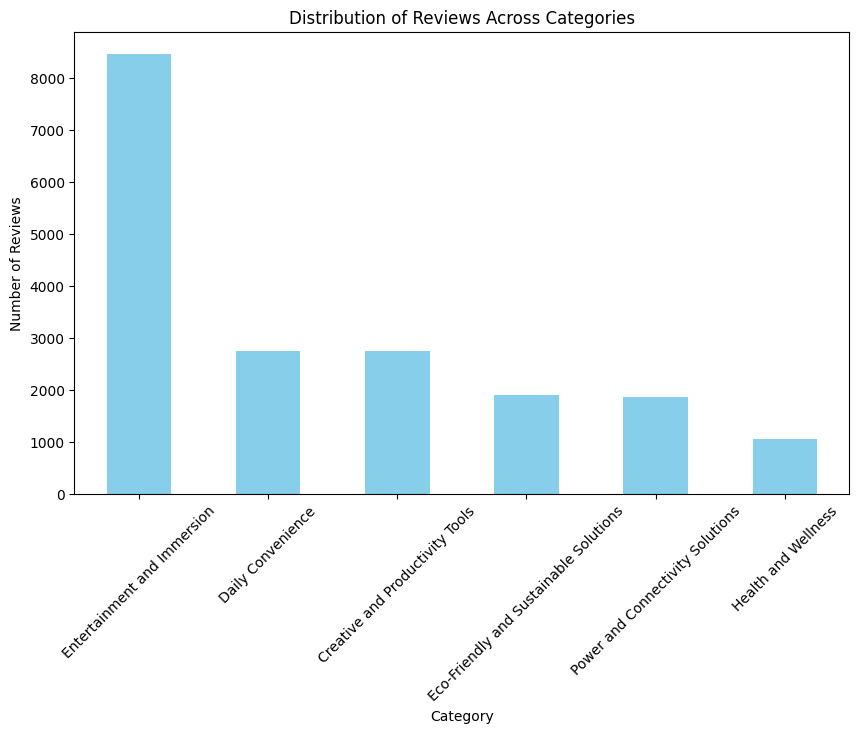

In [136]:
import matplotlib.pyplot as plt

# Load the results
results = pd.read_csv('new_classified_reviews.csv')

# Plot category distribution
category_counts = results['category'].value_counts()
category_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Distribution of Reviews Across Categories')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()


In [139]:

results = chunk_results
low_confidence_reviews = results[results['confidence'] < 0.5] # Now 'results' has the 'confidence' column
print("Low-confidence reviews:")
print(low_confidence_reviews[['reviews.text', 'category', 'confidence']].head())


Low-confidence reviews:
                                            reviews.text  \
15000                     Excellent value for the money.   
15001  Excellent value, and the batteries last just a...   
15002  Excellent value, still going strong in all the...   
15003                                   Excellent value!   
15004                                   Excellent value.   

                               category  confidence  
15000   Creative and Productivity Tools    0.231893  
15001  Power and Connectivity Solutions    0.476759  
15002   Creative and Productivity Tools    0.260661  
15003   Creative and Productivity Tools    0.261789  
15004   Creative and Productivity Tools    0.272557  


In [140]:
# Filter reviews for "Entertainment and Immersion"
entertainment_reviews = results[results['category'] == 'Entertainment and Immersion']
print("Sample Entertainment Reviews:")
print(entertainment_reviews['reviews.text'].head(10))


Sample Entertainment Reviews:
15017                                Exelent
15018    Extremely happy with this purchase!
15022                             Fanastic!!
15023                   Fantastic batteries!
15036                        Feel the power!
15040                             First rate
15163                        good batteriess
15185                              good buy.
15224                       Good experience.
15225               good for the cheap price
Name: reviews.text, dtype: object


In [141]:
# Filter short or generic reviews in "Entertainment and Immersion"
short_reviews = entertainment_reviews[entertainment_reviews['reviews.text'].str.len() < 20]
print("Short Reviews in 'Entertainment and Immersion':")
print(short_reviews[['reviews.text', 'category']].head(10))


Short Reviews in 'Entertainment and Immersion':
             reviews.text                     category
15017             Exelent  Entertainment and Immersion
15022          Fanastic!!  Entertainment and Immersion
15036     Feel the power!  Entertainment and Immersion
15040          First rate  Entertainment and Immersion
15163     good batteriess  Entertainment and Immersion
15185           good buy.  Entertainment and Immersion
15224    Good experience.  Entertainment and Immersion
15226  Good for the money  Entertainment and Immersion
15227  good for the price  Entertainment and Immersion
15228  good for the price  Entertainment and Immersion


In [143]:
# Filter out low-confidence reviews
filtered_results = results[results['confidence'] >= 0.5]

# Save the filtered results
filtered_results.to_csv('filtered_classified_reviews.csv', index=False)

# Check distribution after filtering
print("Distribution of reviews after filtering:")
print(filtered_results['category'].value_counts())


Distribution of reviews after filtering:
category
Daily Convenience                         161
Power and Connectivity Solutions          127
Entertainment and Immersion                83
Health and Wellness                        53
Creative and Productivity Tools            47
Eco-Friendly and Sustainable Solutions     39
Name: count, dtype: int64


In [144]:
# Load filtered-out reviews
filtered_out_reviews = results[results['confidence'] < 0.5]

# Sample 10 filtered-out reviews for manual inspection
print("Sample of filtered-out reviews:")
print(filtered_out_reviews[['reviews.text', 'confidence']].sample(10))


Sample of filtered-out reviews:
                                            reviews.text  confidence
15659                           Great deal, saved money!    0.268486
17419  great value and seem to last just as long as n...    0.247644
17447                                            It work    0.413997
16499  Put them in my TV clicker and they work. Seem ...    0.274282
17131                  works as well as the other brands    0.215009
16203  Just as good as the store bought batteries BUT...    0.358059
16806                                          They work    0.295039
15804            Great price point and reviews for item.    0.255480
15404                                        good value.    0.308881
16025                                       Great value!    0.257439


In [ ]:
# Enrich input text with product names for better context
results['input_text'] = results['reviews.text'] + " Product: " + results['name']

# Re-run classification using enriched input with the 6 categories
outputs = classifier(
    results['input_text'].tolist(),
    candidate_labels=[
        "Daily Convenience",
        "Creative and Productivity Tools",
        "Health and Wellness",
        "Entertainment and Immersion",
        "Power and Connectivity Solutions",
        "Eco-Friendly and Sustainable Solutions"
    ],
    batch_size=BATCH_SIZE
)

# Update results with new categories and confidence scores
results['category'] = [output['labels'][0] for output in outputs]
results['confidence'] = [output['scores'][0] for output in outputs]

# Save the updated results
results.to_csv('reprocessed_6_categories_reviews.csv', index=False)

# Check updated distribution
print("Updated category distribution:")
print(results['category'].value_counts())



In [ ]:
# Assign "Unclassified" for reviews with confidence below 0.4
results['final_category'] = results.apply(
    lambda row: row['category'] if row['confidence'] >= 0.4 else 'Unclassified',
    axis=1
)

# Save results with fallback category
results.to_csv('final_6_categories_reviews.csv', index=False)

# Check distribution including fallback
print("Final category distribution:")
print(results['final_category'].value_counts())


In [ ]:
# Define keyword-based rules for ambiguous cases
rules = {
    "Power and Connectivity Solutions": ["battery", "charger", "cable", "plug"],
    "Entertainment and Immersion": ["game", "movie", "stream", "screen", "music"],
    "Health and Wellness": ["vitamin", "exercise", "nutrition", "wellness", "yoga"],
    "Daily Convenience": ["kitchen", "home", "daily", "clean", "cook"],
    "Creative and Productivity Tools": ["office", "tool", "work", "project", "creative"],
    "Eco-Friendly and Sustainable Solutions": ["eco", "sustainable", "green", "environment"]
}

# Apply rules for low-confidence reviews
def assign_category_based_on_rules(text):
    for category, keywords in rules.items():
        if any(keyword in text.lower() for keyword in keywords):
            return category
    return "Unclassified"

# Apply rules to low-confidence reviews
results['final_category'] = results.apply(
    lambda row: assign_category_based_on_rules(row['reviews.text'])
    if row['confidence'] < 0.4 else row['category'],
    axis=1
)

# Save final results
results.to_csv('rule_based_6_categories_reviews.csv', index=False)

# Check final distribution
print("Category distribution after applying rules:")
print(results['final_category'].value_counts())



In [ ]:
# Plot final distribution of categories
import matplotlib.pyplot as plt

results['final_category'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Final Distribution of Reviews Across 6 Categories')
plt.xlabel('Category')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Inspect low-confidence reviews assigned by rules
low_confidence_reviews = results[results['confidence'] < 0.4]
print("Low-confidence reviews reassigned by rules:")
print(low_confidence_reviews[['reviews.text', 'final_category']].head())
